# Fase 1: Extracción de características de las imágenes

Además de los procedimientos descritos para la implementación de redes convolucionales, en los que el objetivo principal era precedir el target únicamente a partir de la imagen, decidimos probar este camino de la extracción de características en paralelo.

Una de las ventajas de la extracción de características radica en que nos permite usar, además de las imágenes, las variables de los metadatos, las cuales brindan algo de contextualización respecto al paciente (edad, sexo y lugar anatómico de la lesión). Estas variables de contextualización podrían ser o no importantes para la tarea de clasificación, no podemos saberlo a priori. Por tanto, quisimos probar si incluir estas variables en conjunto con las características de las imágenes podía significar una mejora en el desempeño del modelo (o modelos) a aplicar.

Por otro lado, debido a las limitaciones computacionales, consideramos que la extracción de características nos puede ayudar a disminuir la complejidad y los recursos computacionales requeridos por la tarea de clasificación.

## Librerías

Para la extracción de características usamos principalmente las librerías de skimage y openCV.

In [3]:
#import tensorflow as tf

import numpy as np
import IPython.display as display
import pandas as pd
from PIL import Image
import io

from skimage import data
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage import measure
#import cv2
import math

## Funciones para cargar imágenes

A continuación, presentamos las funciones que aplicamos para cargar las imágenes. La competencia de Kaggle proveía las imágenes en varios formatos (JPG, DICOM y TF Records). Decidimos leer este último formato, para lo cual usamos la librería de Tensor Flow (TF). Las 32,432 imágenes venían en 16 folds de 2,027 imágenes cada uno. Debido a limitaciones de tiempo y de recursos computacionales pudimos extraer las características de 12 folds (24,324 imágenes).

In [3]:
# Create a dictionary describing the features.
image_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_image_function(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def load_image_set(file):
    raw_image_dataset = tf.data.TFRecordDataset(file)
    parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
    return parsed_image_dataset

def plot_some_images(path, limit):
    iset = load_image_set(path)
    k = 0
    for image_features in iset:
        if(k<limit):
            image_raw = image_features['image'].numpy()
            display.display(display.Image(data=image_raw))
            k+=1
        else:
            break
            
def visualize(raw_list):
    for image in raw_list:
        display.display(display.Image(data=image))  

def dataframe_locations(file, dictionary):
    iset = load_image_set(file)
    image_name = []
    target = []
    group = dictionary[file]

    for image_features in iset:
        image_name.append(str(image_features['image_name'].numpy()))
        target.append(int(image_features['target'].numpy()))

    data = {'image name':image_name, 'target':target, 'fold':[group for x in target]}
    return pd.DataFrame(data)

def find_positives(file):
    iset = load_image_set(file)
    image_name = []
    target = []

    for image_features in iset:
        image_name.append(str(image_features['image_name'].numpy()))
        target.append(int(image_features['target'].numpy()))

    data = {'image name':image_name, 'target':target, 'fold':[group for x in target]}
    return pd.DataFrame(data) 

def cleaning(word):
    t = word[2:]
    t = t.replace('"','')
    t = t.replace("'","")
    return str(t)

def search(positive_list, file):
    iset = load_image_set(file)
    images = []
    for image_features in iset:
        image_name = str(image_features['image_name'].numpy())
        image_name_processed = cleaning(image_name)
        if(image_name_processed in positive_list):
            images.append(image_features['image'].numpy())
        else:
            continue
    return dict(zip(positive_list, images))

def set_to_df(path, limit):
    iset = load_image_set(path)
    k=0

    for image_features in iset:
        if(k==limit):
            break
        else:
            r_df, g_df, b_df = image_to_pixels(image_features)
            label = cleaning(str(image_features['image_name'].numpy()))
            r_df.to_csv('r_' + label + '.csv')
            g_df.to_csv('g_' + label + '.csv')
            b_df.to_csv('b_' + label + '.csv')
            k+=1

def image_to_np(image_features):
    image_raw = image_features['image'].numpy()
    image = Image.open(io.BytesIO(image_raw))
    img_array = np.array(image)
    return img_array
    
def image_to_pixels(image_features):

    pixels_red = []
    pixels_green = []
    pixels_blue = []

    image_raw = image_features['image'].numpy()
    image = Image.open(io.BytesIO(image_raw))
    img_array = np.array(image)

    for l in range(3):
        for i in range(1024):
            for j in range(1024):
                if(l==0):
                    pixels_red.append(img_array[i,j,l])
                elif(l==1):
                    pixels_green.append(img_array[i,j,l])
                elif(l==2):
                    pixels_blue.append(img_array[i,j,l])

    r_df = pd.DataFrame(columns=[str(x) for x in range(1,1025)])
    g_df = pd.DataFrame(columns=[str(x) for x in range(1,1025)])
    b_df = pd.DataFrame(columns=[str(x) for x in range(1,1025)])
    
    for i in range(1024):
        r_df.loc[i+1] = pixels_red[i*1024:(i+1)*1024]
        g_df.loc[i+1] = pixels_green[i*1024:(i+1)*1024]
        b_df.loc[i+1] = pixels_blue[i*1024:(i+1)*1024]

    return r_df, g_df, b_df

## Preparación de las imágenes y extracción de características

Explicaremos paso a paso el procedimiento y las funciones aplicadas para la extracción de las características más importantes. Mostraremos el procedimiento de extracción para una sola imagen.

Primero se lee el conjunto de imágenes y se convierten todas a arreglos de Numpy para su manipulación. (Ejemplo para el primer fold de imágenes).

In [22]:
#Esta primera parte es para ir guardando los nombres de las imágenes
files_dictionary = {'tfrecords/train/train00-2071.tfrec':1}
fold1 = dataframe_locations('tfrecords/train/train00-2071.tfrec', files_dictionary)
fold1['image name'] = fold1['image name'].apply(lambda x: cleaning(x))
#Esta es para convertir las imágenes a arreglos de Numpy
raw_image_dataset = tf.data.TFRecordDataset('tfrecords/train/train00-2071.tfrec')
unitas = load_image_set('tfrecords/train/train00-2071.tfrec')
unitas_np = []
for i in unitas:
    unitas_np.append(image_to_np(i))

Para probar que estamos leyendo bien las imágenes, imprimimos una de las imágenes del conjunto que importamos.

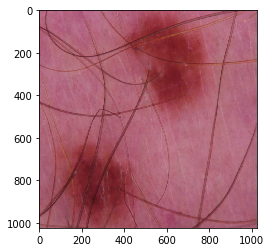

In [24]:
ejemplo = unitas_np[0]
plt.imshow(ejemplo)

### Funciones para extraer características

Varias de las funciones a continuación extraen características de las imágenes y las representan en números. El procedimiento para la extracción de características es el siguiente:

1. Remover los pelos de la imagen (*hair_remove()*): los vellos corpolares que se aprecian en la mayoría de las imágenes son un obstáculo para detectar características importantes como el número de lesiones presentadas y el color. Si bien los vellos podrían ser un indicio de malignidad, no los tendremos en cuenta en esta etapa de extracción de características debido a la dificultad que suponen para detectar objetos.

2. Extraer la media y cuartiles del histograma de cada canal de color (*colores()*): parches de tonos distintos en una lesión pueden indicar malignidad, por lo cual representar el histograma de cada canal de color puede ser importante en la tarea de clasificación.

3. Binarizar la imagen aplicando Otsu Thresholding (*binaria()*) con el fin de:
    * Calcular el tamaño (procentaje de ocupación) de la lesión (*tam_lesion()*)
    
    * Encontrar contornos en la imagen para identificar objetos/lesiones (*contornos()*)
    
    * Encontrar el mínimo círculo envolvente de las lesiones para generar medidas de irregularidad de los bordes y asimetría (suelen ser signos de malignidad). Estas medidas se calculan comparando el perímetro y el área del contorno de la lesión con el perímetro y el área (respectivamente) del mínimo círculo envolvente de la lesión. En particular, para la medida de asimetría se calculó la distancia Chi Cuadrado para la proyección en X y Y de las lesiones binarias. Como cada imagen puede tener muchas lesiones (o el algoritmo puede identificar muchas) estas medidas se ponderan por el porcentaje de ocupación de las lesiones (para tener en cuenta su 'relevancia' en la imagen).

In [4]:
def hair_remove(image):
    """Le quita los pelos a la imagen"""
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   
    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))
    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)
    return final_image

def resolucion(image):
    """Calcula la resolución de la imagen"""
    res = image.shape[0]*image.shape[1]
    return res

def colores(image):
    """Calcula la media, percentil 25, percentil 50 y percentil 75 del histograma de cada canal de color"""
    red = [image[:,:,0].mean(),np.percentile(image[:,:,0],25),np.percentile(image[:,:,0],50),np.percentile(image[:,:,0],75)]
    green = [image[:,:,1].mean(),np.percentile(image[:,:,1],25),np.percentile(image[:,:,1],50),np.percentile(image[:,:,1],75)]
    blue = [image[:,:,2].mean(),np.percentile(image[:,:,2],25),np.percentile(image[:,:,2],50),np.percentile(image[:,:,2],75)]
    return(red,green,blue)

def binaria(image):
    """Devuelve una imagen binaria con Otsu thresholding"""
    #Primero es necesario pasar la imagen a escala de grises
    gray = rgb2gray(image)
    #Aplica threshold óptimo
    thresh = threshold_otsu(gray)
    binary_global =gray > thresh
    return(binary_global)

def tam_lesion(image):
    """Calcula el porcentaje de pixeles ocupados por la lesión a partir de una imagen binaria"""
    #Calcula el porcentaje de pixeles negros sobre el total
    porcentaje = 1-sum(sum(image))/image.size
    return porcentaje

def contornos(image):
    """Encuentra los contornos más importantes a partir de una imagen binaria"""
    contours = measure.find_contours(image,0.1)
    # Create list with the shape of each contour
    shape_contours = [cnt.shape[0] for cnt in contours]
    min_les_shape = np.mean(shape_contours) + 3*np.std(shape_contours)
    # Count lesions in contours excluding smaller than lesion size
    lesion_contours = [cnt for cnt in contours if np.shape(cnt)[0] > min_les_shape]
    return lesion_contours

def num_lesiones(contornos):
    """Retorna el número de lesiones encontradas"""
    num = len(contornos)
    return num

def chi2_distance(histA, histB, eps = 1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps) for (a, b) in zip(histA, histB)])
    # return the chi-squared distance
    return d

def bordes(contornos,image):
    """Retorna el promedio ponderado del cociente del perímetro del contorno y el perímetro del círculo envolvente"""
    """Retorna el promedio ponderado del cociente del área del contorno y el área del círculo envolvente"""
    """Retorna el promedio ponderado de la distancia Chi Cuadrado para la proyección de la lesión binaria en X y Y 
    a partir de imagen binaria"""
    if len(contornos) == 0:
        medida_per = 0
        medida_ar = 0
        medida_chi = 0
    else:
        raw_perimetro = []
        raw_area = []
        areas = []
        perimetros = []
        raw_chi = []
        for contorno in contornos:
            #Enclosing Circle
            ensayito = contorno.astype(np.int32)
            (x,y),radius = cv2.minEnclosingCircle(ensayito)
            center = (int(y),int(x))
            radius = int(radius)
            raw_perimetro.append((len(contorno)) / (math.pi*radius*2))
            raw_area.append((cv2.contourArea(ensayito))/(math.pi*(radius**2)))
            perimetros.append(len(contorno))
            areas.append(cv2.contourArea(ensayito))
            #Bounding rectangle
            x,y,w,h = cv2.boundingRect(ensayito)
            #new_global = image.astype(np.float32)
            mid_h = round(h/2)
            mid_w = round(w/2)
            ROI = image[y:y+h, x:x+w]
            ROI_x = sum(ROI)
            ROI_y = sum(ROI.transpose())
            #Cálculo de la distancia chi cuadrado
            raw_chi.append(chi2_distance(ROI_x,ROI_y))
        medida_per = sum((np.array(raw_perimetro))*((np.array(perimetros))/(max(perimetros))))
        medida_ar = sum((np.array(raw_area))*((np.array(areas))/(max(areas))))
        medida_chi = sum((np.array(raw_chi))*((np.array(areas))/(max(areas))))
    return(medida_per,medida_ar,medida_chi)

def show_image(image, title = 'Image', cmap_type = 'gray'):
    plt.imshow(image,cmap = cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [5]:
arch = 'tfrecords/train/train12-2071.tfrec'
arch[21:23]

'12'

La rutina a continuación implementa las funciones de extracción de características a cada imagen del fold y las guarda en un DataFrame, el cual luego se exporta a un archivo csv.

In [7]:
archivos = ['tfrecords/train/train15-2061.tfrec']

for archivo in archivos:
    files_dictionary = {archivo:1}
    fold1 = dataframe_locations(archivo, files_dictionary)
    fold1['image name'] = fold1['image name'].apply(lambda x: cleaning(x))
    #Esta es para convertir las imágenes a arreglos de Numpy
    raw_image_dataset = tf.data.TFRecordDataset(archivo)
    unitas = load_image_set(archivo)
    unitas_np = []
    for i in unitas:
        unitas_np.append(image_to_np(i))

    nombre,target,fold = [],[],[]
    res = []
    r_mean,r_25,r_50,r_75,g_mean,g_25,g_50,g_75,b_mean,b_25,b_50,b_75 = [],[],[],[],[],[],[],[],[],[],[],[]
    l_size,les,per,ar,sym = [],[],[],[],[]
    for imagen in range(len(fold1['image name'])):
        #Identificar imagen
        nombre.append(fold1['image name'][imagen])
        target.append(fold1['target'][imagen])
        fold.append(fold1['fold'][imagen])
        #Aplicar funciones de una vez a la imagen
        imagen_sin_pelos = hair_remove(unitas_np[imagen])
        colors = colores(imagen_sin_pelos)
        imagen_binaria = binaria(imagen_sin_pelos)
        contours = contornos(imagen_binaria)
        borders = bordes(contours,imagen_binaria)
        #Llenar las listas correspondientes a cada variable
        res.append(resolucion(imagen_sin_pelos))
        r_mean.append(colors[0][0]), r_25.append(colors[0][1]), r_50.append(colors[0][2]), r_75.append(colors[0][3])
        g_mean.append(colors[1][0]), g_25.append(colors[1][1]), g_50.append(colors[1][2]), g_75.append(colors[1][3])
        b_mean.append(colors[2][0]), b_25.append(colors[2][1]), b_50.append(colors[2][2]), b_75.append(colors[2][3])
        l_size.append(tam_lesion(imagen_binaria))
        les.append(num_lesiones(contours))
        per.append(borders[0])
        ar.append(borders[1])
        sym.append(borders[2])
    diccionario = {'name': nombre,'target': target,'fold': fold,'res': res,
                'color_red_mean': r_mean,'color_red_25': r_25,'color_red_50': r_50,'color_red_75': r_75,
                'color_green_mean': g_mean,'color_green_25': g_25,'color_green_50': g_50,'color_green_75': g_75,
                'color_blue_mean': b_mean,'color_blue_25': b_mean,'color_blue_50': b_50,'color_blue_75': b_75,
                'lesion_size': l_size,'lesions': les,'border_perimeter': per,'border_area': ar,'symmetry': sym}
    datos_imagenes = pd.DataFrame(diccionario)
    datos_imagenes.to_csv(f'imagenes_fold{archivo[21:23]}.csv',index=False)

Al correr el código de extracción de imágenes para cada fold se genera un data frame como el que se muestra a continuación:

In [25]:
diccionario = {'name': nombre,'target': target,'fold': fold,'res': res,
                'color_red_mean': r_mean,'color_red_25': r_25,'color_red_50': r_50,'color_red_75': r_75,
                'color_green_mean': g_mean,'color_green_25': g_25,'color_green_50': g_50,'color_green_75': g_75,
                'color_blue_mean': b_mean,'color_blue_25': b_mean,'color_blue_50': b_50,'color_blue_75': b_75,
                'lesion_size': l_size,'lesions': les,'border_perimeter': per,'border_area': ar,'symmetry': sym}
datos_imagenes = pd.DataFrame(diccionario)
datos_imagenes

,name,target,fold,res,color_red_mean,color_red_25,color_red_50,color_red_75,color_green_mean,color_green_25,...,color_green_75,color_blue_mean,color_blue_25,color_blue_50,color_blue_75,lesion_size,lesions,border_perimeter,border_area,symmetry
0,ISIC_0340091,0,1,1048576,177.618250,173.0,180.0,186.0,158.403103,153.0,...,170.0,139.658319,139.658319,145.0,159.0,0.134399,8,8.551665,0.600041,14641.961301
1,ISIC_8536138,0,1,1048576,203.767402,200.0,206.0,210.0,133.269692,131.0,...,145.0,146.135996,146.135996,154.0,160.0,0.100033,1,3.079479,0.601221,18190.448342
2,ISIC_0483872,0,1,1048576,239.215497,237.0,243.0,247.0,193.656579,189.0,...,207.0,203.084232,203.084232,212.0,220.0,0.041057,1,2.662530,0.662033,3073.858263
3,ISIC_3082466,0,1,1048576,241.924043,239.0,243.0,247.0,200.599302,197.0,...,207.0,218.996045,218.996045,223.0,227.0,0.136148,18,11.897834,0.669238,4635.200716
4,ISIC_4150885,0,1,1048576,232.804461,228.0,236.0,241.0,189.059897,184.0,...,200.0,182.430356,182.430356,192.0,198.0,0.133602,4,4.122012,0.785658,11264.781880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2066,ISIC_1582030,0,1,1048576,179.881363,132.0,218.0,231.0,139.096685,98.0,...,179.0,163.793065,163.793065,191.0,216.0,0.328897,1,1.706612,0.572505,6321.862947
2067,ISIC_8199327,0,1,1048576,202.860868,186.0,210.0,225.0,160.413174,142.0,...,181.0,146.364913,146.364913,149.0,164.0,0.378686,3,2.974125,0.471643,86847.200280
2068,ISIC_6146097,0,1,1048576,182.643413,181.0,190.0,195.0,127.591741,125.0,...,146.0,75.352169,75.352169,86.0,95.0,0.162229,1,1.943928,0.531526,25727.968600
2069,ISIC_8523143,0,1,1048576,241.858806,238.0,244.0,247.0,192.046341,189.0,...,199.0,180.700757,180.700757,186.0,192.0,0.065540,6,4.137857,0.506985,10661.737360


Se guarda el dataframe resultante en un archivo csv:

In [14]:
datos_imagenes.to_csv('imagenes_fold1.csv',index=False)

### Ejemplo de tratamiento y extracción de características para una imagen

#### Quitar los pelos de las imágenes

Vamos a quitar los pelos porque es mucho más difícil identificar las lesiones si tienen los pelos.
Aunque el "número" de pelos también puede ser importante, no lo tendremos en cuenta por ahora.

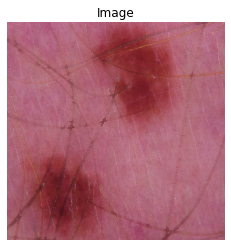

In [27]:
sin_pelos = hair_remove(ejemplo)
show_image(sin_pelos)

#### Histogramas de colores

Histograma para el canal rojo:

<function matplotlib.pyplot.show(*args, **kw)>

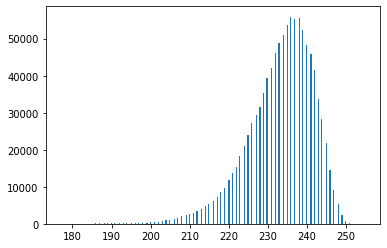

In [201]:
plt.hist(sin_pelos[:,:,0].ravel(),bins=256)
plt.show

Medidas que describen el histograma (ejemplo para el canal rojo):

In [29]:
print('Media del canal rojo: '+ str(colores(sin_pelos)[0][0]))
print('Percentil 25 del canal rojo: ' + str(colores(sin_pelos)[0][1]))
print('Percentil 50 del canal rojo: '+ str(colores(sin_pelos)[0][2]))
print('Percentil 75 del canal rojo: '+ str(colores(sin_pelos)[0][3]))

Media del canal rojo: 166.47811889648438
Percentil 25 del canal rojo: 160.0
Percentil 50 del canal rojo: 173.0
Percentil 75 del canal rojo: 179.0


Estas medidas se extraen para cada canal de color.

#### Tamaño de la imagen:

In [14]:
print(resolucion(sin_pelos))

1048576


#### Thresholding

Hacemos esto para identificar regiones importantes de la imagen (ej. el tamaño de la lesión o porcentaje que ocupa dentro de la imagen)

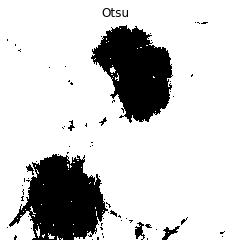

In [32]:
image = rgb2gray(sin_pelos)
thresh = threshold_otsu(image)
binary_global =image > thresh
show_image(binary_global, 'Otsu')

#### Porcentaje ocupado por las lesiones:

In [18]:
print(tam_lesion(sin_pelos))

0.22520923614501953


#### Contours

Vamos a tratar de medir la asimetría y la irregularidad de los bordes, comparando el área y el perímetro del contour con el área y perímetro del mínimo círculo envolvente de cada lesión.

#### Primer paso: hallar los contours con mayor perímetro

In [30]:
def show_image_contour(image,contours,title, cmap_type = 'gray'):
    plt.imshow(image,cmap = cmap_type)
    for n, contour in enumerate(contours):
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    plt.title(title)
    plt.axis('off')
    plt.show()

En la siguiente imagen de ejemplo, se pueden ver las lesiones que identifica el algoritmo. Es posible ver que identifica 3 lesiones (aunque en realidad parece haber solamente 2). Tratamos de controlar esta identificación de lesiones seleccionando siempre los contornos que tienen un perímetro que está 3 desviaciones estándar por encima de la media.

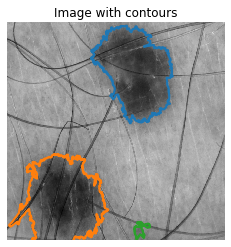

In [33]:
from skimage import measure
new_gray = rgb2gray(unitas_np[0])
contours = measure.find_contours(binary_global,0.1)
# Create list with the shape of each contour
shape_contours = [cnt.shape[0] for cnt in contours]
min_les_shape = np.mean(shape_contours) + 3*np.std(shape_contours)
# Count lesions in contours excluding smaller than lesion size
lesion_contours = [cnt for cnt in contours if np.shape(cnt)[0] > min_les_shape]
show_image_contour(new_gray, lesion_contours,'Image with contours')

#### Segundo paso: Minimum enclosing circle

Por cada contour que encuentra el algoritmo, identificamos el mínimo círculo envolvente con el cual vamos a comparar la lesión para así calcular medidas de irregularidad y asimetría (una lesión que se parece más a un círculo es 'menos sospechosa')

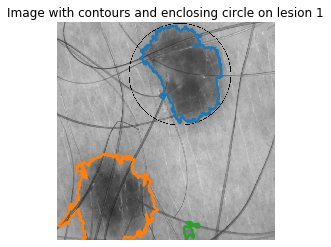

In [35]:
ensayito = lesion_contours[0].astype(np.int32)
(x,y),radius = cv2.minEnclosingCircle(ensayito)
#center = (int(x),int(y))
center = (int(y),int(x))
radius = int(radius)
copia = new_gray.copy()
img = cv2.circle(copia,center,radius,(0,255,0),2)
show_image_contour(img, lesion_contours,'Image with contours and enclosing circle on lesion 1')

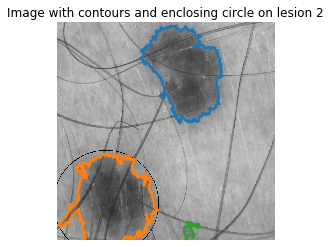

In [36]:
ensayito = lesion_contours[1].astype(np.int32)
(x,y),radius = cv2.minEnclosingCircle(ensayito)
#center = (int(x),int(y))
center = (int(y),int(x))
radius = int(radius)
copia = new_gray.copy()
img = cv2.circle(copia,center,radius,(0,255,0),2)
show_image_contour(img, lesion_contours,'Image with contours and enclosing circle on lesion 2')

# Fase 2: Construcción de la base de datos, limpieza, selección de variables y modelamiento

## Librerías

In [4]:
import pandas as pd
import numpy as np
import os, os.path
#from pandas_profiling import ProfileReport 
from sklearn.model_selection import train_test_split,GridSearchCV
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix

## Unión de bases y limpieza de datos

Cargaremos los datos generados con las funciones construidas para la extracción de características.

In [6]:
unidos = []
for name in os.listdir('datos'):
    unidos.append(pd.read_csv(f'datos/{name}'))

In [7]:
imagenes = pd.concat(unidos,ignore_index=True)
imagenes.rename(columns={'name': 'image_name'}, inplace=True)
imagenes

,image_name,target,fold,res,color_red_mean,color_red_25,color_red_50,color_red_75,color_green_mean,color_green_25,...,color_green_75,color_blue_mean,color_blue_25,color_blue_50,color_blue_75,lesion_size,lesions,border_perimeter,border_area,symmetry
0,ISIC_3139230,0,1,1048576,166.478119,160.0,173.0,179.0,89.815660,80.0,...,106.0,104.862576,104.862576,116.0,125.0,0.225209,3,4.930065,1.194976,22412.122930
1,ISIC_1939931,0,1,1048576,233.259930,229.0,235.0,239.0,189.240341,184.0,...,197.0,187.677483,187.677483,190.0,196.0,0.309001,13,11.849137,1.023370,5692.001899
2,ISIC_8681290,0,1,1048576,207.709061,198.0,208.0,220.0,181.885701,158.0,...,212.0,149.196536,149.196536,169.0,192.0,0.307974,1,2.078830,0.439481,11550.262295
3,ISIC_5403296,0,1,1048576,246.974982,243.0,248.0,252.0,203.315379,198.0,...,210.0,202.332554,202.332554,205.0,211.0,0.363570,4,9.623909,0.346536,39548.341125
4,ISIC_5598875,0,1,1048576,156.131313,151.0,172.0,179.0,109.747829,93.0,...,135.0,87.601157,87.601157,101.0,112.0,0.223027,1,2.750807,0.788707,35578.486717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33121,ISIC_6364051,0,1,1048576,207.774188,201.0,211.0,218.0,151.632744,142.0,...,166.0,108.475203,108.475203,113.0,129.0,0.270607,18,15.848794,0.744451,12483.897993
33122,ISIC_4645138,0,1,1048576,158.911049,159.0,163.0,167.0,126.179429,128.0,...,139.0,98.931044,98.931044,106.0,113.0,0.101813,1,2.047011,0.722330,5978.122219
33123,ISIC_1626843,0,1,1048576,226.889365,222.0,228.0,233.0,212.364884,207.0,...,220.0,187.880247,187.880247,194.0,201.0,0.282482,10,6.874796,0.496407,59097.946406
33124,ISIC_6927363,0,1,1048576,238.599991,229.0,248.0,255.0,229.731646,222.0,...,255.0,214.271784,214.271784,238.0,255.0,0.152864,2,2.665520,0.546665,24195.019951


Ahora cargaremos la Metadata y haremos un join entre los dos DataFrames para producir la base con la que realizaremos el análisis y posteriormente entrenaremos el modelo.

In [9]:
metadata = pd.read_csv('train.csv')
metadata

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0


Realizamos una limpieza inicial de la base eliminando las siguientes columnas: 
  * <b> image_name: </b> es el identificador de la imagen, no aporte en nada al análisis.
  * <b>target_y:</b> es igual a la variable target_x.
  * <b>fold: </b> no aporta nada pues solo indica en qué partición se encontraba la imagen.
  * <b>diagnosis: </b> eliminamos esta variable porque es prácticamente igual a nuestro target. Si un nuevo dato llegara y conociéramos el diagnóstico dado por el médico, no tendría mucho sentido hacer la predicción sobre si es maligno o no. La idea no es propiamente predecir un diagnóstico, sino si la lesión es benigna o maligna (sin conocer el diagnóstico).
  * <b>benign_malignant: </b> esta variable es igual a nuestro target (1 = maligno, 0 = benigno).

In [10]:
data = pd.merge(metadata,imagenes,on='image_name')
data = data.drop(columns=['image_name','target_y','fold','diagnosis','benign_malignant'])
data

,patient_id,sex,age_approx,anatom_site_general_challenge,target_x,res,color_red_mean,color_red_25,color_red_50,color_red_75,...,color_green_75,color_blue_mean,color_blue_25,color_blue_50,color_blue_75,lesion_size,lesions,border_perimeter,border_area,symmetry
0,IP_7279968,male,45.0,head/neck,0,1048576,223.474159,217.0,225.0,232.0,...,160.0,167.425461,167.425461,169.0,182.0,0.413511,14,8.518387,0.307735,38009.574709
1,IP_3075186,female,45.0,upper extremity,0,1048576,226.113372,222.0,228.0,233.0,...,183.0,138.251954,138.251954,141.0,151.0,0.239197,11,7.176799,0.334348,65827.311674
2,IP_2842074,female,50.0,lower extremity,0,1048576,198.802560,199.0,204.0,210.0,...,142.0,141.863201,141.863201,152.0,158.0,0.106670,1,1.957359,0.536425,16842.155310
3,IP_6890425,female,45.0,head/neck,0,1048576,117.585741,84.0,124.0,152.0,...,85.0,54.376907,54.376907,54.0,78.0,0.467651,2,3.403179,0.412681,24203.502449
4,IP_8723313,female,55.0,upper extremity,0,1048576,233.742517,230.0,235.0,240.0,...,190.0,156.966773,156.966773,162.0,173.0,0.258852,20,10.724609,0.489212,3153.509262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33121,IP_6526534,male,50.0,torso,0,1048576,201.800116,195.0,206.0,212.0,...,188.0,169.574810,169.574810,175.0,183.0,0.253407,15,11.449321,0.733377,20523.564836
33122,IP_3650745,male,65.0,torso,0,1048576,250.652633,249.0,252.0,254.0,...,217.0,222.113796,222.113796,224.0,230.0,0.239330,12,11.585961,0.634340,15759.455244
33123,IP_2026598,male,20.0,lower extremity,0,1048576,172.302573,169.0,173.0,177.0,...,122.0,96.624077,96.624077,100.0,104.0,0.132500,1,3.861050,0.617681,18901.902339
33124,IP_7702038,male,50.0,lower extremity,0,1048576,149.483623,149.0,153.0,157.0,...,113.0,120.051651,120.051651,124.0,129.0,0.063800,1,2.134381,0.753787,9843.765662


### Tratamiento de datos faltantes

Realizaremos el mismo tratamiento de datos faltantes descrito en la entrega 2.

In [11]:
data = data[~((data.age_approx.isna()) | (data.age_approx.isna()))]
data['anatom_site_general_challenge'] = data['anatom_site_general_challenge'].fillna('unknown')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Análisis de correlaciones

Antes de comenzar con el análisis, separaremos los datos en Train y Test, con el fin de no sesgarnos al analizar la muestra de Test.

In [12]:
y = data['target_x']
X = data.drop(columns=['target_x'])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
X_train.head()

,patient_id,sex,age_approx,anatom_site_general_challenge,res,color_red_mean,color_red_25,color_red_50,color_red_75,color_green_mean,...,color_green_75,color_blue_mean,color_blue_25,color_blue_50,color_blue_75,lesion_size,lesions,border_perimeter,border_area,symmetry
12307,IP_3846489,male,45.0,torso,1048576,212.517230,214.0,219.0,223.0,164.983087,...,178.0,104.380484,104.380484,112.0,116.0,0.062028,1,1.695612,0.603673,8370.549204
9121,IP_5889408,female,45.0,torso,1048576,238.589851,237.0,240.0,243.0,193.447500,...,202.0,172.269634,172.269634,180.0,188.0,0.088620,3,5.687957,1.001587,7061.903307
18376,IP_3789216,male,45.0,lower extremity,1048576,189.925126,187.0,192.0,195.0,121.651371,...,131.0,140.818000,140.818000,144.0,149.0,0.068774,7,7.126802,0.838080,1164.028257
20522,IP_3423256,female,60.0,upper extremity,1048576,231.359479,226.0,233.0,238.0,204.857245,...,211.0,205.546580,205.546580,207.0,214.0,0.383964,11,8.427066,0.276011,30747.816585
19817,IP_2325148,male,70.0,head/neck,1048576,195.783080,178.0,202.0,221.0,140.483282,...,167.0,142.038651,142.038651,141.0,173.0,0.461612,4,4.486324,0.286165,22875.381471


In [14]:
corr = X_train.corr()
corr

,age_approx,res,color_red_mean,color_red_25,color_red_50,color_red_75,color_green_mean,color_green_25,color_green_50,color_green_75,color_blue_mean,color_blue_25,color_blue_50,color_blue_75,lesion_size,lesions,border_perimeter,border_area,symmetry
age_approx,1.000000,NaN,-0.040595,-0.033184,-0.044469,-0.052384,-0.084273,-0.072153,-0.092448,-0.105148,-0.047123,-0.047123,-0.054996,-0.060841,0.080619,0.141988,0.141339,0.023847,0.016797
res,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
color_red_mean,-0.040595,NaN,1.000000,0.984871,0.991550,0.976368,0.892651,0.888148,0.882140,0.851352,0.860437,0.860437,0.852779,0.834052,-0.395812,0.296832,0.305947,0.158962,-0.275495
color_red_25,-0.033184,NaN,0.984871,1.000000,0.972074,0.933716,0.878476,0.902637,0.869352,0.814492,0.851761,0.851761,0.847116,0.806869,-0.463056,0.289633,0.301506,0.174384,-0.322570
color_red_50,-0.044469,NaN,0.991550,0.972074,1.000000,0.985202,0.881000,0.869425,0.885266,0.855760,0.846416,0.846416,0.850927,0.833403,-0.420619,0.263866,0.269935,0.160233,-0.265134
color_red_75,-0.052384,NaN,0.976368,0.933716,0.985202,1.000000,0.868957,0.836274,0.868723,0.868048,0.827156,0.827156,0.826168,0.832873,-0.348627,0.252482,0.253455,0.136421,-0.221453
color_green_mean,-0.084273,NaN,0.892651,0.878476,0.881000,0.868957,1.000000,0.980702,0.990303,0.975218,0.921309,0.921309,0.914651,0.906952,-0.416069,0.268180,0.277072,0.143320,-0.271257
color_green_25,-0.072153,NaN,0.888148,0.902637,0.869425,0.836274,0.980702,1.000000,0.967476,0.922470,0.917352,0.917352,0.909585,0.873521,-0.499317,0.273111,0.283864,0.164357,-0.341932
color_green_50,-0.092448,NaN,0.882140,0.869352,0.885266,0.868723,0.990303,0.967476,1.000000,0.980196,0.906844,0.906844,0.918262,0.906783,-0.461859,0.219888,0.227742,0.149614,-0.268106
color_green_75,-0.105148,NaN,0.851352,0.814492,0.855760,0.868048,0.975218,0.922470,0.980196,1.000000,0.876060,0.876060,0.880927,0.905364,-0.365439,0.196125,0.199343,0.116113,-0.201541


Vemos que hay una alta correlación entre las variables que se refieren al color, sobre todo porque las variables de la media y de la mediana de los histogramas de color están altamente relacionadas. Así que, quitaremos estas variables, al igual que la variable que hace referencia a la resolución de las imágenes (es constante).

In [15]:
X_train = X_train.drop(columns=['color_red_mean','color_green_mean','color_blue_mean','res',
                                'color_red_50','color_green_50','color_blue_50'])
X_test = X_test.drop(columns=['color_red_mean','color_green_mean','color_blue_mean','res',
                              'color_red_50','color_green_50','color_blue_50'])
X_train.head()

,patient_id,sex,age_approx,anatom_site_general_challenge,color_red_25,color_red_75,color_green_25,color_green_75,color_blue_25,color_blue_75,lesion_size,lesions,border_perimeter,border_area,symmetry
12307,IP_3846489,male,45.0,torso,214.0,223.0,166.0,178.0,104.380484,116.0,0.062028,1,1.695612,0.603673,8370.549204
9121,IP_5889408,female,45.0,torso,237.0,243.0,191.0,202.0,172.269634,188.0,0.088620,3,5.687957,1.001587,7061.903307
18376,IP_3789216,male,45.0,lower extremity,187.0,195.0,117.0,131.0,140.818000,149.0,0.068774,7,7.126802,0.838080,1164.028257
20522,IP_3423256,female,60.0,upper extremity,226.0,238.0,200.0,211.0,205.546580,214.0,0.383964,11,8.427066,0.276011,30747.816585
19817,IP_2325148,male,70.0,head/neck,178.0,221.0,114.0,167.0,142.038651,173.0,0.461612,4,4.486324,0.286165,22875.381471


In [16]:
corr = X_train.corr()
corr

,age_approx,color_red_25,color_red_75,color_green_25,color_green_75,color_blue_25,color_blue_75,lesion_size,lesions,border_perimeter,border_area,symmetry
age_approx,1.000000,-0.033184,-0.052384,-0.072153,-0.105148,-0.047123,-0.060841,0.080619,0.141988,0.141339,0.023847,0.016797
color_red_25,-0.033184,1.000000,0.933716,0.902637,0.814492,0.851761,0.806869,-0.463056,0.289633,0.301506,0.174384,-0.322570
color_red_75,-0.052384,0.933716,1.000000,0.836274,0.868048,0.827156,0.832873,-0.348627,0.252482,0.253455,0.136421,-0.221453
color_green_25,-0.072153,0.902637,0.836274,1.000000,0.922470,0.917352,0.873521,-0.499317,0.273111,0.283864,0.164357,-0.341932
color_green_75,-0.105148,0.814492,0.868048,0.922470,1.000000,0.876060,0.905364,-0.365439,0.196125,0.199343,0.116113,-0.201541
color_blue_25,-0.047123,0.851761,0.827156,0.917352,0.876060,1.000000,0.977306,-0.415275,0.282358,0.291658,0.143014,-0.286920
color_blue_75,-0.060841,0.806869,0.832873,0.873521,0.905364,0.977306,1.000000,-0.376965,0.220598,0.226055,0.123112,-0.228499
lesion_size,0.080619,-0.463056,-0.348627,-0.499317,-0.365439,-0.415275,-0.376965,1.000000,0.220405,0.226341,-0.203841,0.536656
lesions,0.141988,0.289633,0.252482,0.273111,0.196125,0.282358,0.220598,0.220405,1.000000,0.917664,0.357732,-0.081008
border_perimeter,0.141339,0.301506,0.253455,0.283864,0.199343,0.291658,0.226055,0.226341,0.917664,1.000000,0.430422,-0.095909


### Tratamiento de variables categóricas

Eliminaremos la variable Patient ID, debido a la gran cantidad de pacientes que tiene la base y la dificultad de representar apropiadamente la variable (muchos pacientes aparecen una sola vez). Las variables de sexo y sitio anatómico de la lesión se convertirán usando One Hot Encoding.

In [17]:
X_train = X_train.drop(columns=['patient_id'])
X_test = X_test.drop(columns=['patient_id'])

Sitio de la lesión a One Hot Encoding:

In [18]:
X_train['anatom_site_general_challenge'] = X_train['anatom_site_general_challenge'].astype(str)
X_train = pd.get_dummies(X_train, columns=['anatom_site_general_challenge'])
X_test['anatom_site_general_challenge'] = X_test['anatom_site_general_challenge'].astype(str)
X_test = pd.get_dummies(X_test, columns=['anatom_site_general_challenge'])
X_train

,sex,age_approx,color_red_25,color_red_75,color_green_25,color_green_75,color_blue_25,color_blue_75,lesion_size,lesions,border_perimeter,border_area,symmetry,anatom_site_general_challenge_head/neck,anatom_site_general_challenge_lower extremity,anatom_site_general_challenge_oral/genital,anatom_site_general_challenge_palms/soles,anatom_site_general_challenge_torso,anatom_site_general_challenge_unknown,anatom_site_general_challenge_upper extremity
12307,male,45.0,214.0,223.0,166.0,178.0,104.380484,116.0,0.062028,1,1.695612,0.603673,8370.549204,0,0,0,0,1,0,0
9121,female,45.0,237.0,243.0,191.0,202.0,172.269634,188.0,0.088620,3,5.687957,1.001587,7061.903307,0,0,0,0,1,0,0
18376,male,45.0,187.0,195.0,117.0,131.0,140.818000,149.0,0.068774,7,7.126802,0.838080,1164.028257,0,1,0,0,0,0,0
20522,female,60.0,226.0,238.0,200.0,211.0,205.546580,214.0,0.383964,11,8.427066,0.276011,30747.816585,0,0,0,0,0,0,1
19817,male,70.0,178.0,221.0,114.0,167.0,142.038651,173.0,0.461612,4,4.486324,0.286165,22875.381471,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27906,male,30.0,193.0,203.0,151.0,162.0,94.508772,107.0,0.087571,1,1.533885,0.683034,5434.205102,0,0,0,0,0,0,1
27339,female,55.0,194.0,211.0,126.0,145.0,150.538919,173.0,0.133110,1,2.187377,0.784376,4946.306833,0,1,0,0,0,0,0
581,male,40.0,168.0,200.0,98.0,156.0,95.108006,131.0,0.271778,1,3.052680,0.700871,41123.895926,0,0,0,0,1,0,0
2445,female,45.0,246.0,254.0,211.0,223.0,194.925195,204.0,0.252559,7,8.533034,0.570509,9975.408120,0,0,0,0,0,1,0


Sexo del paciente a One Hot Encoding:

In [19]:
X_train['sex'] = X_train['sex'].astype(str)
X_train = pd.get_dummies(X_train, columns=['sex'])
X_train = X_train.drop(columns=['sex_male'])
X_test['sex'] = X_test['sex'].astype(str)
X_test = pd.get_dummies(X_test, columns=['sex'])
X_test = X_test.drop(columns=['sex_male'])
X_train

,age_approx,color_red_25,color_red_75,color_green_25,color_green_75,color_blue_25,color_blue_75,lesion_size,lesions,border_perimeter,border_area,symmetry,anatom_site_general_challenge_head/neck,anatom_site_general_challenge_lower extremity,anatom_site_general_challenge_oral/genital,anatom_site_general_challenge_palms/soles,anatom_site_general_challenge_torso,anatom_site_general_challenge_unknown,anatom_site_general_challenge_upper extremity,sex_female
12307,45.0,214.0,223.0,166.0,178.0,104.380484,116.0,0.062028,1,1.695612,0.603673,8370.549204,0,0,0,0,1,0,0,0
9121,45.0,237.0,243.0,191.0,202.0,172.269634,188.0,0.088620,3,5.687957,1.001587,7061.903307,0,0,0,0,1,0,0,1
18376,45.0,187.0,195.0,117.0,131.0,140.818000,149.0,0.068774,7,7.126802,0.838080,1164.028257,0,1,0,0,0,0,0,0
20522,60.0,226.0,238.0,200.0,211.0,205.546580,214.0,0.383964,11,8.427066,0.276011,30747.816585,0,0,0,0,0,0,1,1
19817,70.0,178.0,221.0,114.0,167.0,142.038651,173.0,0.461612,4,4.486324,0.286165,22875.381471,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27906,30.0,193.0,203.0,151.0,162.0,94.508772,107.0,0.087571,1,1.533885,0.683034,5434.205102,0,0,0,0,0,0,1,0
27339,55.0,194.0,211.0,126.0,145.0,150.538919,173.0,0.133110,1,2.187377,0.784376,4946.306833,0,1,0,0,0,0,0,1
581,40.0,168.0,200.0,98.0,156.0,95.108006,131.0,0.271778,1,3.052680,0.700871,41123.895926,0,0,0,0,1,0,0,0
2445,45.0,246.0,254.0,211.0,223.0,194.925195,204.0,0.252559,7,8.533034,0.570509,9975.408120,0,0,0,0,0,1,0,1


### Escalamiento de los datos

Realizaremos un escalamiento MinMax de los datos con el fin de poder aplicar modelos que no son inmunes a la escala de las variables.

In [20]:
pipeline_cleaning = Pipeline([
 ('normalization', MinMaxScaler(feature_range=(0, 1))),
 ])
columns_train, columns_test = X_train.columns, X_test.columns
X_train, X_test = pipeline_cleaning.fit_transform(X_train),pipeline_cleaning.fit_transform(X_test)
X_train, X_test = pd.DataFrame(X_train,columns=columns_train), pd.DataFrame(X_test,columns=columns_test)
X_train

,age_approx,color_red_25,color_red_75,color_green_25,color_green_75,color_blue_25,color_blue_75,lesion_size,lesions,border_perimeter,border_area,symmetry,anatom_site_general_challenge_head/neck,anatom_site_general_challenge_lower extremity,anatom_site_general_challenge_oral/genital,anatom_site_general_challenge_palms/soles,anatom_site_general_challenge_torso,anatom_site_general_challenge_unknown,anatom_site_general_challenge_upper extremity,sex_female
0,0.500000,0.839216,0.846154,0.650980,0.675105,0.420508,0.452756,0.059904,0.012821,0.035383,0.111194,0.052332,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.500000,0.929412,0.942308,0.749020,0.776371,0.696541,0.736220,0.087253,0.038462,0.118692,0.184488,0.044151,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.500000,0.733333,0.711538,0.458824,0.476793,0.568661,0.582677,0.066843,0.089744,0.148716,0.154371,0.007277,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.666667,0.886275,0.918269,0.784314,0.814346,0.831842,0.838583,0.390997,0.141026,0.175849,0.050840,0.192234,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.777778,0.698039,0.836538,0.447059,0.628692,0.573624,0.677165,0.470854,0.051282,0.093617,0.052710,0.143016,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26441,0.333333,0.756863,0.750000,0.592157,0.607595,0.380371,0.417323,0.086174,0.012821,0.032008,0.125812,0.033974,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
26442,0.611111,0.760784,0.788462,0.494118,0.535865,0.608185,0.677165,0.133008,0.012821,0.045644,0.144479,0.030924,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
26443,0.444444,0.658824,0.735577,0.384314,0.582278,0.382807,0.511811,0.275621,0.012821,0.063701,0.129098,0.257105,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
26444,0.500000,0.964706,0.995192,0.827451,0.864979,0.788656,0.799213,0.255855,0.089744,0.178060,0.105085,0.062366,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


### Over sampling y Over and Under sampling

Debido a que el conjunto de datos está muy desbalanceado, debemos aplicar una técnica para abordar este problema. Aplicaremos SMOTE, técnica que implementa el over sampling para igualar el tamaño de la clase minoritaria (lesiones malignas) al de la clase mayoritaria (lesiones benignas). También aplicaremos la técnica SMOTE Tomek, la cual es una mezcla de over y under sampling: aplica SMOTE y luego limpia un poco el ruido de la base.

Al aplicar SMOTE, tenemos una base de 51924 datos.

In [22]:
from collections import Counter
from imblearn.over_sampling import SMOTE
X_train_SMOTE, y_train_SMOTE = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train_SMOTE).items()))

C:\Users\dm.ortiz11\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0, 25962), (1, 25962)]


Al aplicar SMOTE Tomek, tenemos una base de 51912 datos

In [23]:
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
X_train_SMOTETomek, y_train_SMOTETomek = smote_tomek.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_SMOTETomek).items()))

C:\Users\dm.ortiz11\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0, 25956), (1, 25956)]


C:\Users\dm.ortiz11\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Modelo con el over sampling

### Modelos de ensamblaje

Aplicamos el grid search con los modelos de ensamblaje, calibrando el número de estimadores a probar.

In [34]:
from sklearn.naive_bayes import BernoulliNB
estimators = [('clf', BaggingClassifier(base_estimator=BernoulliNB(), random_state=0))]
pipe = Pipeline(estimators)
param_grid = dict(clf = [RandomForestClassifier(random_state=0,n_jobs=-1),
                         BaggingClassifier(base_estimator=BernoulliNB(), random_state=0,n_jobs=-1),
                         AdaBoostClassifier(random_state=0)],
                  clf__n_estimators=[10,20,50,70],
                  )
grid_search_EN = GridSearchCV(pipe, param_grid=param_grid,verbose = 20,error_score=0.0,cv=3)
grid_search_EN.fit(X_train_SMOTETomek,y_train_SMOTETomek)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=10, score=0.977, total=   0.7s
[CV] clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=10, score=0.981, total=   0.7s
[CV] clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=10, score=0.982, total=   0.7s
[CV] clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=20 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s


[CV]  clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=20, score=0.982, total=   1.0s
[CV] clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=20 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.0s remaining:    0.0s


[CV]  clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=20, score=0.985, total=   1.1s
[CV] clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=20 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.1s remaining:    0.0s


[CV]  clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=20, score=0.984, total=   1.0s
[CV] clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=50 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.0s remaining:    0.0s


[CV]  clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=50, score=0.985, total=   2.3s
[CV] clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=50 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.3s remaining:    0.0s


[CV]  clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=50, score=0.987, total=   2.1s
[CV] clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=50 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    9.4s remaining:    0.0s


[CV]  clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=50, score=0.986, total=   2.0s
[CV] clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=70 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   11.5s remaining:    0.0s


[CV]  clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=70, score=0.985, total=   2.8s
[CV] clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=70 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.4s remaining:    0.0s


[CV]  clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=70, score=0.987, total=   3.0s
[CV] clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=70 


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   17.4s remaining:    0.0s


[CV]  clf=RandomForestClassifier(n_jobs=-1, random_state=0), clf__n_estimators=70, score=0.987, total=   2.9s
[CV] clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=10 


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   20.3s remaining:    0.0s


[CV]  clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=10, score=0.573, total=   0.5s
[CV] clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=10 


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   20.8s remaining:    0.0s


[CV]  clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=10, score=0.570, total=   0.5s
[CV] clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=10 


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   21.3s remaining:    0.0s


[CV]  clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=10, score=0.569, total=   0.4s
[CV] clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=20 


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   21.7s remaining:    0.0s


[CV]  clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=20, score=0.570, total=   0.6s
[CV] clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=20 


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   22.3s remaining:    0.0s


[CV]  clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=20, score=0.570, total=   0.7s
[CV] clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=20 


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   23.0s remaining:    0.0s


[CV]  clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=20, score=0.569, total=   0.7s
[CV] clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=50 


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   23.7s remaining:    0.0s


[CV]  clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=50, score=0.570, total=   1.5s
[CV] clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=50 


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   25.2s remaining:    0.0s


[CV]  clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=50, score=0.570, total=   1.3s
[CV] clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=50 
[CV]  clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=50, score=0.569, total=   1.3s
[CV] clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=70 
[CV]  clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=70, score=0.570, total=   1.7s
[CV] clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=70 
[CV]  clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=70, score=0.570, total=   1.7s
[CV] clf=BaggingClassifier(base_estimator=BernoulliNB(), n_jobs=-1, random_state=0), clf__n_estimators=70 
[CV]  clf=BaggingClassifier(base

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.1min finished


GridSearchCV(cv=3, error_score=0.0,
             estimator=Pipeline(steps=[('clf',
                                        BaggingClassifier(base_estimator=BernoulliNB(),
                                                          random_state=0))]),
             param_grid={'clf': [RandomForestClassifier(n_estimators=70,
                                                        n_jobs=-1,
                                                        random_state=0),
                                 BaggingClassifier(base_estimator=BernoulliNB(),
                                                   n_jobs=-1, random_state=0),
                                 AdaBoostClassifier(random_state=0)],
                         'clf__n_estimators': [10, 20, 50, 70]},
             verbose=20)

In [35]:
grid_search_EN.best_estimator_

Pipeline(steps=[('clf',
                 RandomForestClassifier(n_estimators=70, n_jobs=-1,
                                        random_state=0))])

El mejor modelo, encontrado por el Grid Search resultó ser de nuevo un RandomForest con 50 estimadores.

In [36]:
EN = grid_search_EN.best_estimator_
y_pred_EN = EN.predict(X_test)
y_pred_EN

array([1, 1, 1, ..., 0, 1, 0], dtype=int64)

In [37]:
report_EN = classification_report(y_test, y_pred_EN,target_names=['benigno','maligno'])

print("Test Report for Ensemblers\n", report_EN)
print("Confusion Matrix for Ensemblers\n", confusion_matrix(y_test, y_pred_EN))

Test Report for Ensemblers
               precision    recall  f1-score   support

     benigno       0.99      0.83      0.90      6512
     maligno       0.03      0.33      0.05       100

    accuracy                           0.82      6612
   macro avg       0.51      0.58      0.48      6612
weighted avg       0.97      0.82      0.89      6612

Confusion Matrix for Ensemblers
 [[5379 1133]
 [  67   33]]


### Support Vector Machine

In [39]:
estimators = [
              ('clasificar', SVC(kernel='rbf',random_state=33,class_weight='balanced',cache_size=1024))
              ]
pipe = Pipeline(estimators)
param_grid = dict(
    clasificar__gamma=[0.1,0.5,1],
    clasificar__C=[0.1,0.5,1],
    )

grid = GridSearchCV(pipe, param_grid=param_grid,verbose = 20,cv=3,n_jobs=-1)
grid.fit(X_train_SMOTETomek,y_train_SMOTETomek)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  8

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('clasificar',
                                        SVC(cache_size=1024,
                                            class_weight='balanced',
                                            random_state=33))]),
             n_jobs=-1,
             param_grid={'clasificar__C': [0.1, 0.5, 1],
                         'clasificar__gamma': [0.1, 0.5, 1]},
             verbose=20)

In [40]:
grid.best_estimator_

Pipeline(steps=[('clasificar',
                 SVC(C=1, cache_size=1024, class_weight='balanced', gamma=1,
                     random_state=33))])

In [41]:
svm = grid.best_estimator_
y_pred_svm = svm.predict(X_test)
y_pred_svm

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [42]:
report_svm = classification_report(y_test, y_pred_svm,target_names=['benigno','maligno'])

print("Test Report for Ensemblers\n", report_svm)
print("Confusion Matrix for Ensemblers\n", confusion_matrix(y_test, y_pred_svm))

Test Report for Ensemblers
               precision    recall  f1-score   support

     benigno       0.99      0.82      0.90      6512
     maligno       0.05      0.62      0.09       100

    accuracy                           0.81      6612
   macro avg       0.52      0.72      0.49      6612
weighted avg       0.98      0.81      0.88      6612

Confusion Matrix for Ensemblers
 [[5323 1189]
 [  38   62]]


## Análisis de resultados

Es posible ver que el desempeño del modelo todavía es bastante pobre en cuanto a la detección de melanomas, pero mejoró un poco gracias al tratamiento del desbalance.

En cuanto a la aplicación de la técnica de over y under sampling, no vimos una mejora significativa en cuanto al desempeño del modelo, en comparación con la técnica de únicamente over sampling (SMOTE).

El modelo de Support Vector Machine mejora la medida de recall en comparación con los modelos de ensamblaje, por lo que preferiríamos aplicar este modelo en vez de los ensamblajes en un contexto real. 

### Posibles acciones de mejora

* Probar modelos un poco más complejos, aprovechando la gran cantidad de datos que generamos gracias al over sampling (Redes Neuronales). 